<a href="https://colab.research.google.com/github/AnaWhatever16/Biomedical_assigment_1/blob/main/Information_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BIOMEDICAL INFORMATICS (MUIA): INFORMATION RETRIEVAL ASSIGMENT**

By: Ana María Casado Faulí ([GitHub](https://github.com/AnaWhatever16)) & Ángel Pavón Pérez ([GitHub](https://github.com/angelpavon97))

---
<font color='yellow'> WARNING: </font>

To be able to share the code more easily between the authors, we have developed this code in Google Colab, so some parts of the code may make reference to Google Drive parameters. We encourage to try the code using this Drive shared folder: [LINK TO FOLDER](https://drive.google.com/drive/folders/1xEQ4s8jsH9TvwSUkjMqzXZtX3z3a1ZUr?usp=sharing). 

You just have to **create a direct access to the folder in your own Drive** and you will be able to compile it using the same documents and paths as we did. Google Colab does not support local compiling so don't worry if the library related to it does not work. Just delete all dependencies related to this. <font color='yellow'> If you want to compile the code in your own computer/Drive, paths to files have to be changed!</font>

\\

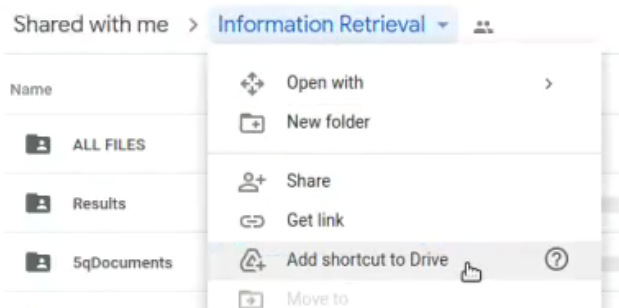

**Execute this only if you are using Google Colab, otherwise ignore it:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # In case you want to use a drive folder

Mounted at /content/drive


---


# **INTRODUCTION**:


---

The aim of this project is to design algorithms to create an information retrieval system based on query-document sets. We have divided the problem in 3 parts, so the search of methods could be more structured:


*   Preprocessing of the text
*   Vector Space Model
*   Metric of similarity

Before we can start with this we have to install a few libraries and extract the text from the documents of the dataset we are going to use (CORD-19 corpus). After that, functions will be defined for each method that we are going to use. To test the functions first we have used a sample corpus with a sentence per document. Once we saw the code did what it should, we then used the whole corpus. Finally, we created evaluation functions to compare the results of our algorithms with what it is given in the relevance judgement document.


---


# **INSTALLS AND DEPENDENCIES**:


---
In this section we are going to simply install and import dependencies we need for all the programs so we can execute all properly.

**NLTK:** NLTK (Natural Language Toolkit) is a leading platform for building Python programs to work with human language data. We are going to use it for the preprocessing of the text.

In [ ]:
pip install nltk

**Gensim:** Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora.

In [ ]:
pip install gensim

**Untangle:** Library for processing XML files.

In [ ]:
pip install untangle

  Created wheel for untangle: filename=untangle-1.1.1-cp36-none-any.whl size=3412 sha256=77401a5c348f00321a4818edba4dbdf619e48a6e4b28e6dffbc90d172426078f
  Stored in directory: /root/.cache/pip/wheels/16/18/ff/b217dc66c822e07c274599310ba25ffce62cda02fc1c0bdca2
Successfully built untangle


After installing all these libraries, we will need to import them (plus some extra libraries): 

In [ ]:
import numpy as np
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
import untangle
import json
import shutil
import csv
import spacy
from gensim import corpora, models, similarities
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter
import pickle
import random

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True



---


# **PATHS:**


---

This part of the code has to be changed to the paths where each of the files are stored in your computer or drive directory, if you are not using the shared folder provided at the beginning of this script. 

In [ ]:
doc_path = '/content/drive/MyDrive/Information Retrieval/ALL FILES/pdf_json' # Path to the folder with all docs
meta_path = '/content/drive/MyDrive/Information Retrieval/metadata.csv' # Path to the metadata file which has the short and long id pairing
xml_path = '/content/drive/MyDrive/Information Retrieval/topics-rnd5.xml' # Path to the XML where queries are
qrels_path = '/content/drive/MyDrive/Information Retrieval/qrels-covid_d5_j0.5-5.txt' # Path to Relevance Judgement file
doc5q_path = '/content/drive/MyDrive/Information Retrieval/5qDocuments' # Path to folder where the documents that are going to be used for the experiments
dict_id_path = '/content/drive/MyDrive/Information Retrieval/dict_id.sav' # Path where the dictionary with long and short id association will be saved (for easier access)
results_path = '/content/drive/MyDrive/Information Retrieval/Results' # Path to where the documents are going to be stored

---


# **FUNCTIONS TO HANDLE INITIAL FILES:**


---

To design our code first we have to explore the different files that are going to be used and how we are going to extract the information from them. 

First we are going to extract the documents that we want to use for our experiments. We would like to have the relevance judgement of the documents we are going to use so first we will look in the Relevance Judgement document and extract the short ids of the documents of the queries we want to explore. Due to the length of the dataset, we have decided to extract documents from just 5 queries. This decision was made because we have about 1000 documents' relevance judgement per query and not many documents repeat in each query, so we considered this more than enough to test our code. To add more documents we just have to change the n_queries variables (up to 50). Also, the metadata file has some errors in the ids so we will only select the documents if we are able to open them. \\

<font color='red'> 
The execution of this function has been commented because the result is already in our drive folders and the computational time could take more than 10 hours. If you are not in Google Colab and you are using this script as a local jupyter notebook you may want to execute this function.</font>

In [ ]:
def extract_docs_from_queries(qrels_path, meta_path, n_queries = 5):

    f = open(qrels_path, "r")

    lines = []

    for line in f:
        if int(line.split()[0]) <= n_queries:
            lines.append(line)

    rows = []

    with open(meta_path, newline='') as csvfile:
        csv_reader = csv.reader(csvfile)

        for row in csv_reader:
            rows.append(row)


    for l in lines:
        short_id = l.split()[2]
        long_id = None

        for row in rows:
            if long_id == None:
                if short_id == row[0]:
                    long_id = row[1]

                    src = doc_path + '/' + long_id + '.json'
                    dst = doc5q_path + '/' + long_id + '.json'

                    try:
                        shutil.copyfile(src, dst)
                    except:
                        long_id = None
                        pass

# extract_docs_from_queries(qrels_path, meta_path, 5)

The documents have as names a long id. The documents in the relevance judgement document are identified by a short id. The association between these ids can be found in the metadata document. To store this information to be more easily accessible, we create a dictionary and save it to be used more easily and to not execute this code everytime (accessing the metadata file takes a lot of time). 





In [ ]:
def create_dict_ids(qrels_path, meta_path, n_queries = 5):
    dictionary = {}

    f = open(qrels_path, "r")

    lines = []

    for line in f:
        if int(line.split()[0]) <= n_queries:
            lines.append(line)

    rows = []

    with open(meta_path, newline='') as csvfile:
        csv_reader = csv.reader(csvfile)

        for row in csv_reader:
            rows.append(row)


    for l in lines:
        short_id = l.split()[2]
        long_id = None

        for row in rows:
            if long_id == None:
                if short_id == row[0]:
                    long_id = row[1]
                    
                    dst = doc5q_path + '/' + long_id + '.json'

                    if os.path.exists(dst) == True:
                        dictionary[long_id] = short_id
                    else:
                        long_id = None
                        pass

    return dictionary

dict_ids = create_dict_ids(qrels_path, meta_path, 5)

with open(dict_id_path, 'wb') as handle:
    pickle.dump(dict_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(dict_id_path, 'rb') as handle:
    dict_ids = pickle.load(handle)

res = key, val = random.choice(list(dict_ids.items())) # Test to see that it has been loaded correctly
print("The random pair is : " + str(res))

The random pair is : ('66e379d3056b17abad6109e97ee6e410b5e800ae', 'l41lq2sc')


This small script tells us how many documents we are going to use in our experiment.

In [ ]:
l = os.listdir(doc5q_path) # dir is your directory path
number_files = len(l)
print('Total number of documents used:',number_files)

Total number of documents used: 4673


Now we are going to extract the queries from the XML file provided. We will extract all of them because this does not take almost any time. 

In [ ]:
def get_queries(path):
    # parse an xml file by name
    obj = untangle.parse(path)

    queries = {}

    for t in obj.topics.topic:
        queries[int(t['number'])] = t.query.cdata

    return queries

Now lets extract the text from our document files. We will be extracting the title, the abstract, and the main text of each document. We looked into the structure of the .json and in the code we can see how the data can be extracted.

In [ ]:
def get_corpus(doc_path):
    corpus = []
    corpus_id = []

    list_dir = os.listdir(doc_path)
    
    for file_name in list_dir:

        with open(doc_path + '/' + file_name, 'r') as f:
            data = f.read()

        obj = json.loads(data) # parse data

        doc_text = ''

        doc_text += obj['metadata']['title'] + ' '

        for chapter in obj['abstract']:
            doc_text += chapter['text'] + ' '

        for chapter in obj['body_text']:
            doc_text += chapter['text'] + ' '

        corpus.append(doc_text)
        corpus_id.append(file_name[:-5])
        
    return corpus, corpus_id



---


# **PREPROCESSING OF THE TEXT:**


---

After extracting the information we need from each document, now we can start designing the Information Retrieval algorithm as it was described in the introduction. So, firstly, we will preprocess the text. This means that we will be "cleaning" the text by eliminating the stopwords, tokenizing each word that remains and, finally, stemming them. We decided to try two different libraries initially to see which one we would be best: 


*   **NLTK**: It is a very complete library with a lot of functions for natural language processing which has been extensively used.
*   **SPACY**: A more modern library that is object oriented and according to its developers is more efficient. 



In [ ]:
def preprocess_document_spacy(doc, stemming = True):

    # Stopwords removal & Lemmatizing tokens using SpaCy
    nlp = spacy.load('en_core_web_sm')
    stop_words = nlp.Defaults.stop_words

    try:
        tokens = nlp(doc)
    except:
        tokens = nlp(doc[:10000])
        
    tokens = [token for token in tokens if not token.is_punct]
    clean = [token for token in tokens if not str(token) in stop_words]

    if stemming == True:
        stemmer = PorterStemmer()
        final = [stemmer.stem(str(word)) for word in clean]

    else:
        final = clean

    return final

In [ ]:
def preprocess_document_nltk(doc, stemming = True):
    stopset = set(stopwords.words('english'))
    
    tokens = wordpunct_tokenize(doc)
    
    clean = [token.lower() for token in tokens if token.lower() not in stopset and len(token) > 2]

    if stemming == True:
        stemmer = PorterStemmer()
        final = [stemmer.stem(word) for word in clean]

    else:
        final = clean
        
    return final

As it can be seen on the example below, the stopwords used by each library are different. For this project we are only going to use spacy because we think it is a more modern approach. We decided to use only one of the libraries because the preprocessing part of the algorithm is the most time consuming part of the system and the results are pretty similar in both libraries.

In [ ]:
f = preprocess_document_nltk('hello our names are Ana and Angel and we want a one zero (10).')
print(f)
f = preprocess_document_spacy('hello our names are Ana and Angel and we want a one zero (10).')
print(f)

['hello', 'name', 'ana', 'angel', 'want', 'one', 'zero']
['hello', 'name', 'ana', 'angel', 'want', 'zero', '10']



---


# **VECTOR SPACE MODELS:**


---

Vector Space Models (VSM) for Information Retrieval are vectors that represent documents and queries as vectors of weights. This means that each vector contains information of the text, being this information for example words or topics. We have decided to try 4 different types of VSM:


*   Doc2Bow
*   Word2Vec
*   FastText
*   Latent Dirichlet Allocation (LDA) 

These methods will be used to create the VSM both for the documents and the queries, so later query-document vector pairs can be compared by different metrics.


**DOC2BOW**

This method creates a list of tuples where we have in each of them a word with its word count (that is why it is called *document to bag of words*).

In [ ]:
def create_docs2bows_vsm(preprocessed_docs):
    
    dictionary = corpora.Dictionary(preprocessed_docs)

    vectors = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

    return dictionary, vectors

**WORD2VEC**

Given a set of documents (corpus), the model analizes the words from each document and tries to use every word to predict the neighbouring words. This is also known as an skip-gram approach.

We have divided this method in two separated functions because both of them will be used for the whole corpus but only one of them (the first one) will be used for the queries.

In [ ]:
def word2vec_doc(doc, w2v_model):
    embeddings = []

    for tok in doc:
        if tok in w2v_model.wv.vocab:
            embeddings.append(w2v_model.wv.word_vec(tok))
        else:
            embeddings.append(np.random.rand(300))

    return np.mean(embeddings, axis=0)

In [ ]:
def create_word2vec_vsm(preprocessed_docs):
    
    w2v_model = models.Word2Vec(preprocessed_docs, size=300, min_count=2,window=5, sg=1,workers=4)

    vectors = []

    for doc in preprocessed_docs:
        embeddings = word2vec_doc(doc, w2v_model)
        vectors.append(embeddings)

    return w2v_model, vectors


**FASTTEXT**

This method is similar to word2vec, as it also uses the skip-gram approach, but also allows training word embeddings from a training corpus with the additional ability to obtain word vectors for out-of-vocabulary words. 

We have divided this method in two separated functions because both of them will be used for the whole corpus but only one of them (the first one) will be used for the queries.

In [ ]:
def fast_doc(doc, fast_model):
    embeddings = []

    for tok in doc:
        if tok in fast_model.wv.vocab:
            embeddings.append(fast_model.wv.word_vec(tok))
        else:
            embeddings.append(np.random.rand(300))

    return np.mean(embeddings, axis=0)

In [ ]:
def create_FastText_vsm(preprocessed_docs):
    
    fast_model = models.FastText(preprocessed_docs, size=300, min_count=2,window=5, sg=1,workers=4)

    vectors = []

    for doc in preprocessed_docs:
        embeddings = fast_doc(doc, fast_model)
        vectors.append(embeddings)

    return fast_model, vectors

**LDA**

This module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents. As it can be seen, before doing LDA, the documents must be processed into Doc2Bow vectors. This is because it needs the words to be processed before choosing the main topics. The number of topics are chosen by the user.

We have divided this method in two separated functions because both of them will be used for the whole corpus but only one of them (the first one) will be used for the queries.

In [ ]:
def lda_doc(doc, lda_model):
    return lda_model[doc]

In [ ]:
def create_LDA_vsm(preprocessed_docs, num_topics = 5):
    
    dictionary, vectors = create_docs2bows_vsm(preprocessed_docs)
    lda_model = models.LdaModel(vectors, id2word=dictionary, num_topics=num_topics)

    docs_topics = []

    for doc in vectors:
        embeddings = lda_doc(doc, lda_model)
        docs_topics.append(embeddings)

    return dictionary, lda_model, docs_topics

---


# **METRICS OF SIMILARITY:**


---

Once the VSM for documents and queries are created, we have to compare them to decide if the document "answers" the query that we are asking. We have chosen 3 different metrics to evaluate the similarity of the vectors:

*   Cosine Similarity
*   TfIdf
*   Hellinger


**COSINE SIMILARITY**

Does the cosine between two word vectors. The value goes from 0 to 1 and when the value is higher, the similarity is higher and when the value is lower the similarity is lower.

In [ ]:
def cosine_metric(query_vector, doc_vectors):

    cs_list = []

    for i,d_vec in enumerate(doc_vectors):
        cs = cosine_similarity(np.array(query_vector).reshape(1, -1),np.array(d_vec).reshape(1, -1))
        cs_list.append((i,cs[0][0]))

    return sorted(cs_list, key=lambda tup: tup[1], reverse=True)

**TFIDF**

This method first calculates the term frequency and inverse document frecuency for each document and uses a similarity matrix based on the cosine metric to calculate the similarity between vectors. The value goes from 0 to 1 and when the value is higher, the similarity is higher and when the value is lower the similarity is lower.

In [ ]:
def create_TF_IDF_model(dictionary, doc_vectors, query_vector):
    tfidf = models.TfidfModel(doc_vectors)

    index = similarities.MatrixSimilarity(doc_vectors, num_features=len(dictionary))

    qtfidf = tfidf[query_vector]
    sim = index[qtfidf]
    ranking = sorted(enumerate(sim), key=itemgetter(1), reverse=True)

    return ranking

**HELLINGER**

This metric is going to be used only with LDA because it calculates the similarity of two pair of topics. The value goes from 0 to 1 and when the value is lower, the similarity is higher and when the value is higher the similarity is lower.

In [ ]:
from gensim.matutils import hellinger

def hellinger_metric(query_topics, docs_topics):

    hell_list = []

    for i,d_topics in enumerate(docs_topics):
        hell = hellinger(query_topics, d_topics)
        hell_list.append((i,hell))

    return sorted(hell_list, key=lambda tup: tup[1], reverse=False)


---


# **MAINS WITH SHORT DOCUMENTS:**


---

To test quickly the algorithms we created these mains that use a sample corpus with a sentence per document. Each main will print the scores of each document to a query ('Human machine interface'), ordered from most similar to least similar document. The document that should be selected with the query is the second one.


**SPACY + DOC2BOW + TFIDF**



In [ ]:
sample_corpus = [
    "Graph minors A survey"
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
]

pdocs = [preprocess_document_spacy(doc) for doc in sample_corpus]
dictionary, doc_vectors = create_docs2bows_vsm(pdocs)
pq = preprocess_document_spacy('Machine interface for lab')
query_vector = dictionary.doc2bow(pq)

ranking = create_TF_IDF_model(dictionary, doc_vectors, query_vector)

for doc, score in ranking:
    print("[ Score = " + "%.3f" % round(score,3) + " ]" + sample_corpus[doc])


[ Score = 0.646 ]Human machine interface for lab abc computer applications
[ Score = 0.178 ]The EPS user interface management system
[ Score = 0.000 ]A survey of user opinion of computer system response time
[ Score = 0.000 ]System and human system engineering testing of EPS
[ Score = 0.000 ]Relation of user perceived response time to error measurement
[ Score = 0.000 ]The generation of random binary unordered trees
[ Score = 0.000 ]The intersection graph of paths in trees
[ Score = 0.000 ]Graph minors IV Widths of trees and well quasi ordering
[ Score = 0.000 ]Graph minors A survey


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


As we can see in the results above, the method has selected a document that corresponds to the input query, although the score is not very high. The TF-IDF approach is widely used in academic works so it is not a surprise that the precision to select the best document is quite good.

**SPACY + WORD2VEC + COSINE METRIC**

In [ ]:
sample_corpus = [
    "Graph minors A survey",
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering"
]

pdocs = [preprocess_document_spacy(doc) for doc in sample_corpus]
w2v_model, doc_vectors = create_word2vec_vsm(pdocs)

pq = preprocess_document_spacy('Human machine interface')
query_vector = word2vec_doc(pq, w2v_model)

cosine_scores = cosine_metric(query_vector, doc_vectors)

for doc, score in cosine_scores:
    print("[ Score = " + "%.3f" % round(score,3) + " ]" + sample_corpus[doc])



[ Score = 0.831 ]Graph minors IV Widths of trees and well quasi ordering
[ Score = 0.831 ]Human machine interface for lab abc computer applications
[ Score = 0.828 ]Relation of user perceived response time to error measurement
[ Score = 0.819 ]The generation of random binary unordered trees
[ Score = 0.795 ]The intersection graph of paths in trees
[ Score = 0.794 ]System and human system engineering testing of EPS
[ Score = 0.766 ]A survey of user opinion of computer system response time
[ Score = 0.727 ]The EPS user interface management system
[ Score = 0.031 ]Graph minors A survey


The results that can be observed above are not as good as before but this can be due to the fact that the cosine metric is simpler than tf-idf (which uses the cosine metric as explained before). Also, the fact that not many words are present, makes the prediction part of the vector have poor results.

**SPACY + FAST TEXT + COSINE METRIC**

In [ ]:
sample_corpus = [
    "Graph minors A survey",
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering"
]

pdocs = [preprocess_document_spacy(doc) for doc in sample_corpus]
fast_model, doc_vectors = create_FastText_vsm(pdocs)

pq = preprocess_document_spacy('Human machine interface')
query_vector = fast_doc(pq, fast_model)

cosine_scores = cosine_metric(query_vector, doc_vectors)

for doc, score in cosine_scores:
    print("[ Score = " + "%.3f" % round(score,3) + " ]" + sample_corpus[doc])


[ Score = 0.847 ]The generation of random binary unordered trees
[ Score = 0.836 ]Human machine interface for lab abc computer applications
[ Score = 0.826 ]Relation of user perceived response time to error measurement
[ Score = 0.823 ]Graph minors IV Widths of trees and well quasi ordering
[ Score = 0.813 ]The intersection graph of paths in trees
[ Score = 0.778 ]System and human system engineering testing of EPS
[ Score = 0.760 ]A survey of user opinion of computer system response time
[ Score = 0.749 ]The EPS user interface management system
[ Score = 0.049 ]Graph minors A survey


As it can be seen, the results are exactly the same as the previous main. The cause of this could be that the corpus is too small to really see the difference between FastText and Word2Vec, and as they use the same metric and both make predictions of neighbours(skip-gram), the results must be similar.

**SPACY + LDA + HELLINGER**

In [ ]:
sample_corpus = [
    "Graph minors A survey",
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering"
]

pdocs = [preprocess_document_spacy(doc) for doc in sample_corpus]
dictionary, lda_model, docs_topics = create_LDA_vsm(pdocs, 9)


pq = preprocess_document_spacy('Human machine interface')
query_topics = lda_model[dictionary.doc2bow(pq)]

ranking = hellinger_metric(query_topics, docs_topics)

for doc, score in ranking:
    print("[ Score = " + "%.3f" % round(score,3) + " ]" + sample_corpus[doc])


[ Score = 0.107 ]Human machine interface for lab abc computer applications
[ Score = 0.737 ]Graph minors A survey
[ Score = 0.753 ]The intersection graph of paths in trees
[ Score = 0.766 ]The EPS user interface management system
[ Score = 0.766 ]System and human system engineering testing of EPS
[ Score = 0.766 ]The generation of random binary unordered trees
[ Score = 0.776 ]Graph minors IV Widths of trees and well quasi ordering
[ Score = 0.776 ]Relation of user perceived response time to error measurement
[ Score = 0.784 ]A survey of user opinion of computer system response time


As it can be seen, this results are very promising. Remember that with the Hellinger metric, the lower the score, more similar are the query and the document.


---


# **MAINS CORD-19 CORPUS**:


---

Now that we have tested our code, we are ready to execute our different methods on the CORD-19 corpus. We will only be looking at documents of five of the queries as defined on the relevance judgment file (qrels-covid_d5_j0.5-5.txt).

The results of each main will be stored in files so they can be studied in detail on the evaluation section.

To reduce computational time, the extraction of the corpus, the queries and the preprocessing of the documents, will be done only once and saved on variables that will be used in all mains. <font color='red'> (The preprocessing could take up to two hours!)

In [ ]:
corpus, corpus_id = get_corpus(doc5q_path)
queries = get_queries(xml_path)

with open(dict_id_path, 'rb') as handle:
    dict_ids = pickle.load(handle)

pdocs = [preprocess_document_spacy(doc) for doc in corpus]

In [ ]:
for i in range(1,6):
    query = queries[i]

    dictionary, doc_vectors = create_docs2bows_vsm(pdocs)
    pq = preprocess_document_spacy(query)
    query_vector = dictionary.doc2bow(pq)

    ranking = create_TF_IDF_model(dictionary, doc_vectors, query_vector)

    f = open(results_path + '/q' + str(i) + '_tfidf_results.txt', 'w')

    for doc, score in ranking:
        f.write(dict_ids[corpus_id[doc]] + ' ' + str(score) + '\n')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
for i in range(1,6):

    query = queries[i]

    w2v_model, doc_vectors = create_word2vec_vsm(pdocs)

    pq = preprocess_document_spacy(query)
    query_vector = word2vec_doc(pq, w2v_model)

    cosine_scores = cosine_metric(query_vector, doc_vectors)

    f = open(results_path + '/q' + str(i) + '_cos_results.txt', 'w')

    for doc, score in cosine_scores:
        f.write(dict_ids[corpus_id[doc]] + ' ' + str(score) + '\n')

Vocabulary size: 104120
Vocabulary size: 104120
Vocabulary size: 104120
Vocabulary size: 104120
Vocabulary size: 104120


In [ ]:
for i in range(1,6):

    query = queries[i]

    fast_model, doc_vectors = create_FastText_vsm(pdocs)

    pq = preprocess_document_spacy(query)
    query_vector = fast_doc(pq, fast_model)

    cosine_scores = cosine_metric(query_vector, doc_vectors)

    f = open(results_path + '/q' + str(i) + '_fast_results.txt', 'w')

    for doc, score in cosine_scores:
        f.write(dict_ids[corpus_id[doc]] + ' ' + str(score) + '\n')


Vocabulary size: 104120
Vocabulary size: 104120
Vocabulary size: 104120
Vocabulary size: 104120
Vocabulary size: 104120


For LDA, as the number of topics has to be given, we decided to set it on 5 topics because the queries we are looking at are five.

In [ ]:
for i in range(1,6):

    query = queries[i]

    dictionary, lda_model, docs_topics = create_LDA_vsm(pdocs, 5)

    pq = preprocess_document_spacy(query)
    query_topics = lda_model[dictionary.doc2bow(pq)]

    ranking = hellinger_metric(query_topics, docs_topics)

    f = open(results_path + '/q' + str(i) + '_hell_results.txt', 'w')

    for doc, score in ranking:
        f.write(dict_ids[corpus_id[doc]] + ' ' + str(score) + '\n')


---


# **EVALUATION:**


---

To finish this project we are going to compare the relevance judgements provided with the results we have obtained. For this purpose, we have created a function that, given the results of the previous code, we show the theoretical relevance judgement associated to the documents. The theoretical relevance judgement values are:


*   0 if not relevant
*   1 if partially relevant
*   2 if relevant


Let's remember that the result files are a .txt file composed of the similarity values associated to the documents and organized in descending order. 

The queries that are going to be tested are shown on the results of the code below:

In [ ]:
queries = get_queries(xml_path)
print('\n', queries[1], '\n', queries[2], '\n', queries[3], '\n', queries[4], '\n', queries[5], '\n')


 coronavirus origin 
 coronavirus response to weather changes 
 coronavirus immunity 
 how do people die from the coronavirus 
 animal models of COVID-19 



This function will print the 5 first results with relevance judgment (which are the ones that have more similarity with the query) and the 5 last results relevance judgment (which are the ones that have less similarity with the query).

The reason to do this is to see more documents that actually have a relevance judgment.

In [ ]:
def evaluate_with_rj(txt_name, limit = 5):

    file_path = results_path + '/' + txt_name
    query = int(txt_name[1])

    with open(dict_id_path, 'rb') as handle:
        dict_ids = pickle.load(handle)
        r_dict_ids = dict((v, k) for k, v in dict_ids.items())

    f = open(qrels_path, "r")

    qrels_dict = {} # dictionary key: short_id value: ranking

    for line in f:
        l = line.split()
        if int(l[0]) == query:
            qrels_dict[l[2]] = l[3]

    txt = open(file_path, "r")

    lines = []
    for line in txt:
        lines.append(line)

    print('\033[92mBest 5 documents for query nº' + str(query) + '\033[0;0m\n')
    
    counter = 0

    for b in lines:
        bs = b.split()

        try:
            file_name = r_dict_ids[bs[0]] + '.json'

            with open(doc5q_path + '/' + file_name, 'r') as f:
                data = f.read()

            obj = json.loads(data) # parse data
            title = obj['metadata']['title'] 

            print('\033[1mid:\033[0;0m ', bs[0] , '\t\033[1mscore:\033[0;0m ', format(bs[1],'.9'), '\t\033[1mrelevance value:\033[0;0m ', qrels_dict[bs[0]], '\t\033[1mtitle:\033[0;0m ', title)
            counter += 1
        except:
            pass

        if counter == limit:
            break

    print('\n\033[91mWorst 5 documents for query nº' + str(query) + '\033[0;0m\n')
    
    counter = 0

    for w in reversed(lines):
        ws = w.split()

        try:
            file_name = r_dict_ids[ws[0]] + '.json'

            with open(doc5q_path + '/' + file_name, 'r') as f:
                data = f.read()

            obj = json.loads(data) # parse data
            title = obj['metadata']['title'] 

            print('\033[1mid:\033[0;0m ', ws[0] , '\t\033[1mscore:\033[0;0m ', format(ws[1],'.9'), '\t\033[1mrelevance value:\033[0;0m ', qrels_dict[ws[0]], '\t\033[1mtitle:\033[0;0m ', title)
            counter += 1
        except:
            pass

        if counter == limit:
            break



    f.close()
    txt.close()   


This main will execute the function for each of the result files.

In [ ]:
for txt in os.listdir(results_path):
    print('\n\033[1m\033[94m------------------------------------------------------------------------------------\n')
    if 'tfidf' in txt:
        print('\033[1m\033[94mDoc2bow + Tfidf method\033[0;0m\n')

    elif 'cos' in txt:
        print('\033[1m\033[94mWord2Vec + Cosine metric method\033[0;0m\n')

    elif 'fast' in txt:
        print('\033[1m\033[94mFastText + Cosine metric method\033[0;0m\n')

    elif 'hell' in txt:
        print('\033[1m\033[94mLDA + Hellinger metric method\033[0;0m\n')

    print('\033[1m\033[94m------------------------------------------------------------------------------------\033[0;0m\n')
    evaluate_with_rj(txt)

print('\n')


------------------------------------------------------------------------------------

Doc2bow + Tfidf method

------------------------------------------------------------------------------------

Best 5 documents for query nº2

id:  2p9j4ksy 	score:  0.3777338 	relevance value:  0 	title:  Severe weather warnings predict fracture epidemics
id:  akb96git 	score:  0.328248 	relevance value:  2 	title:  The Weather Impacts the Outbreak of COVID-19 in Mainland China
id:  h5ufxzv9 	score:  0.3006464 	relevance value:  0 	title:  Comparison of culturable antibiotic-resistant bacteria in polluted and non- polluted air in Beijing, China
id:  5g0almil 	score:  0.2849603 	relevance value:  1 	title:  Weather: driving force behind the transmission of severe acute respiratory syndrome in China?
id:  qi5oq7db 	score:  0.2772714 	relevance value:  0 	title:  The effects of weather on daily emergency ambulance service demand in Taipei: a comparison with Hong Kong

Worst 5 documents for query nº2

id

First, the Doc2Bow + Tfidf method, gives poor results as it can be seen, for most of the queries the highest scores do not correspond with the highest ranking (2) classified by relevance judgment. The  possible reason of these poor results is that document information given by the Doc2Bow vector is just the term frequency without providing more interesting information.

Secondly, the Word2Vec + Cosine metric method, as it can be seen the results are quite better than the previous method, giving usually good scores to the relevant documents and bad scores on the not relevant documents. This improvment could be because Word2Vec gives more information about the document than Doc2Bow as tries to predict what the neighbouring of the word would be.

Thridly, the FastText + Cosine metric method, as it can be seen the results are slightly better than Word2Vec method and this could be because the difference between FastText and Doc2Vec is that FastText tries also to predict with words that are not in the document so it has a better vision of the problem. In fact, looking at the titles, we have seen that some documents were well classified but the relevance valu given was not correct. An example of this can be seen in query 5 (animal models of COVID-19) where the document with the title "Commentary on two reports on animal models of COVID-19" had a relevance judgment of 0.

Lastly, the LDA + Hellinger metric method depends a lot of the number of topic that the user chooses to classify. In some tests with 50 and 5 topics, we saw that the results were slighlty better than Doc2Bow + tfidf methods but quite worse than Word2Vec and FastText. This could be because on these methods what we look for are the relationships between words and in LDA we are looking just for topics which are more reduced.

---

The next function will print the 5 first results (which are the ones that have more similarity with the query) and the 5 last results (which are the ones that have less similarity with the query). Not all the documents may have a relevance judgment because we have tested all the documents instead of just the documents that were extracted for a specific query. In this way, those documents will indicate that they do not have a relevance judgment. 

We decided to do this because we wanted to see if there were other documents that could be relevant to the query but were associated to other queries.

In [ ]:
def evaluate(txt_name):

    file_path = results_path + '/' + txt_name
    query = int(txt_name[1])

    with open(dict_id_path, 'rb') as handle:
        dict_ids = pickle.load(handle)
        r_dict_ids = dict((v, k) for k, v in dict_ids.items())

    f = open(qrels_path, "r")

    qrels_dict = {} # dictionary key: short_id value: ranking

    for line in f:
        l = line.split()
        if int(l[0]) == query:
            qrels_dict[l[2]] = l[3]

    txt = open(file_path, "r")

    lines = []
    for line in txt:
        lines.append(line)

    best_five = lines[:5]
    worst_five = lines[-5:]

    print('\033[92mBest 5 documents for query nº' + str(query) + '\033[0;0m\n')
    
    for b in best_five:
        bs = b.split()

        file_name = r_dict_ids[bs[0]] + '.json'

        with open(doc5q_path + '/' + file_name, 'r') as f:
            data = f.read()

        obj = json.loads(data) # parse data
        title = obj['metadata']['title'] 

        try:
            print('\033[1mid:\033[0;0m ', bs[0] , '\t\033[1mscore:\033[0;0m ', format(bs[1],'.9'), '\t\033[1mrelevance value:\033[0;0m ', qrels_dict[bs[0]], '\t\t\033[1mtitle:\033[0;0m ', title)
        except:
            print('\033[1mid:\033[0;0m ', bs[0] , '\t\033[1mscore:\033[0;0m ', format(bs[1],'.9'), '\t\033[1mrelevance value:\033[0;0m Not Found', '\t\033[1mtitle:\033[0;0m ', title)

    print('\n\033[91mWorst 5 documents for query nº' + str(query) + '\033[0;0m\n')
    
    for w in reversed(worst_five):
        ws = w.split()

        file_name = r_dict_ids[ws[0]] + '.json'

        with open(doc5q_path + '/' + file_name, 'r') as f:
            data = f.read()

        obj = json.loads(data) # parse data
        title = obj['metadata']['title'] 

        try:
            print('\033[1mid:\033[0;0m ', ws[0] , '\t\033[1mscore:\033[0;0m ', format(ws[1],'.9'), '\t\033[1mrelevance value:\033[0;0m ', qrels_dict[ws[0]], '\t\t\033[1mtitle:\033[0;0m ', title)
        except:
            print('\033[1mid:\033[0;0m ', ws[0] , '\t\033[1mscore:\033[0;0m ', format(ws[1],'.9'), '\t\033[1mrelevance value:\033[0;0m Not Found', '\t\033[1mtitle:\033[0;0m ', title)


    f.close()
    txt.close()   



This main will execute the function for each of the result files.

In [ ]:
for txt in os.listdir(results_path):
    print('\n\033[1m\033[94m------------------------------------------------------------------------------------\n')
    if 'tfidf' in txt:
        print('\033[1m\033[94mDoc2bow + Tfidf method\033[0;0m\n')

    elif 'cos' in txt:
        print('\033[1m\033[94mWord2Vec + Cosine metric method\033[0;0m\n')

    elif 'fast' in txt:
        print('\033[1m\033[94mFastText + Cosine metric method\033[0;0m\n')

    elif 'hell' in txt:
        print('\033[1m\033[94mLDA + Hellinger metric method\033[0;0m\n')

    print('\033[1m\033[94m------------------------------------------------------------------------------------\033[0;0m\n')
    evaluate(txt)

print('\n')


------------------------------------------------------------------------------------

Doc2bow + Tfidf method

------------------------------------------------------------------------------------

Best 5 documents for query nº2

id:  kftchnhz 	score:  0.4094840 	relevance value:  0 		title:  Advice-giving in newspaper weather commentaries
id:  2p9j4ksy 	score:  0.3777338 	relevance value:  0 		title:  Severe weather warnings predict fracture epidemics
id:  akb96git 	score:  0.328248 	relevance value:  2 		title:  The Weather Impacts the Outbreak of COVID-19 in Mainland China
id:  h5ufxzv9 	score:  0.3006464 	relevance value:  0 		title:  Comparison of culturable antibiotic-resistant bacteria in polluted and non- polluted air in Beijing, China
id:  5g0almil 	score:  0.2849603 	relevance value:  1 		title:  Weather: driving force behind the transmission of severe acute respiratory syndrome in China?

Worst 5 documents for query nº2

id:  xa8b1nuo 	score:  0.0 	relevance value: Not Found 

As it can be seen Word2Vec is still  giving poor results while Word2Vec and FastText are giving good results showing more documents that do not have a relevance judgment associated to the query. For example, on query number 2 (coronavirus response to weather changes) document with id *thb2pox2* which talks about weather impact on coronavirus would be also related to this query (as our model has predicted).


---


# **CONCLUSIONS:**


---

Doing this project, we have realized that one of the most important partes of Information Retrieval  is the preprocessing of the corpus, it is not only the most time consuming part, it is also critical for having a good analysis.

Also, we have realized that the datasets provided were not as good as we thought it would be. Not all the documents followed the same structure (in the json files) and that is why in many cases we could not get an id from the metadata, a title from the json, etc. Furthermore, the relevance judgments had some mistakes as proven on the previos evaluation. If we had only taken into account the value of relevance judgments and we had not look on the documents, we would have never found out that some of the relevance judgment were not precise.

On the other hand, although tf-idf is a commonly used method is a very simple text representation. Other methods as Word2Vec and FastText that try to make predictions have proven, at least for this corpus, that perform better. This is probably because the text representation of this two methods is more complex and provide more information than tf-idf. LDA started as a very promising method but it finally dissapointed us due to the poor that it has given. Despite of this, the results are promising (especially in Word2Vec and FastText), although they are far from perfect and an improvment could be made.

In conclusion, the Information Retrieval problem is very complex and depends a lot on the data provided but we hope that in the future new methods will be designed  to approach this problem in a better way.

# <font color= 'lightpink'> **We hope this project has been interesting to you!**

---


# **BIBLIOGRAPHY:**


---



[1] “COVID-19 Open Research Dataset Challenge (CORD-19).” https://kaggle.com/allen-institute-for-ai/CORD-19-research-challenge (accessed Dec. 16, 2020)

[2] “Natural Language Toolkit — NLTK 3.5 documentation.” https://www.nltk.org/ (accessed Dec. 16, 2020).

[3] “spaCy · Industrial-strength Natural Language Processing in Python.” https://spacy.io/ (accessed Dec. 16, 2020).

[4] “Doc2Bow implementation.” https://radimrehurek.com/gensim/corpora/dictionary.html?highlight=doc2bow#gensim.corpora.dictionary.Dictionary.doc2bow (accessed Dec. 16, 2020).

[5] “Word2Vec implementation.” https://radimrehurek.com/gensim/models/word2vec.html?highlight=word2vec#module-gensim.models.word2vec (accessed Dec. 16, 2020).

[6] “FastText implementation.” https://radimrehurek.com/gensim/models/fasttext.html?highlight=fasttext#module-gensim.models.fasttext (accessed Dec. 16, 2020).

[7] Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the Association for Computational Linguistics, 5, 135-146.

[8] “LDA implementation.” https://radimrehurek.com/gensim/models/ldamodel.html (accessed Dec. 16, 2020).

[9] “Hellinger metric implementation.” https://radimrehurek.com/gensim/matutils.html?highlight=hellinger#gensim.matutils.hellinger (accessed Dec. 16, 2020).
